# Base Imports

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import tensorflow_hub as hub
import spacy
import matplotlib.pyplot as plt
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joaco\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joaco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history, metrics = ['accuracy', 'F1']):
  plt.figure(figsize=(14, 10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.history[metric], color=colors[0], label='train')
    plt.plot(history.history['val_'+metric],
             color=colors[0], linestyle="--", label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

# Load Data

In [27]:
TRAIN_SIZE = 0.85
PATH = 'data/'

#"Odio", "Mujeres", "Comunidad LGBTQ+", "Comunidades Migrantes", "Pueblos Originarios"
classes = ["Odio", "Mujeres", "Comunidad LGBTQ+", "Comunidades Migrantes", "Pueblos Originarios"]
data_train = pd.read_csv(PATH+'tweets_train.csv')

train_data = data_train.sample(frac=1).reset_index(drop=True)
train_data, val_data = train_data.iloc[:int(TRAIN_SIZE*len(train_data)), :], train_data.iloc[int(TRAIN_SIZE*len(train_data)):, :]

print(train_data.shape)
print(val_data.shape)

(1917, 10)
(339, 10)


# Preprocess Data

## Nivel considerado odio

In [28]:
NIVEL_PARA_ODIO = 2

if NIVEL_PARA_ODIO == 3:
    # Considerar que un dato pertenece solo si las 3 personas pusieron que pertenece
    train_data['Odio'] = np.where(train_data['Odio'] == 3, 1, 0)
    val_data['Odio'] = np.where(val_data['Odio'] == 3, 1, 0)
    train_data['Mujeres'] = np.where(train_data['Mujeres'] == 3, 1, 0)
    val_data['Mujeres'] = np.where(val_data['Mujeres'] == 3, 1, 0)
    train_data['Comunidad LGBTQ+'] = np.where(train_data['Comunidad LGBTQ+'] == 3, 1, 0)
    val_data['Comunidad LGBTQ+'] = np.where(val_data['Comunidad LGBTQ+'] == 3, 1, 0)
    train_data['Comunidades Migrantes'] = np.where(train_data['Comunidades Migrantes'] == 3, 1, 0)
    val_data['Comunidades Migrantes'] = np.where(val_data['Comunidades Migrantes'] == 3, 1, 0)
    train_data['Pueblos Originarios'] = np.where(train_data['Pueblos Originarios'] == 3, 1, 0)
    val_data['Pueblos Originarios'] = np.where(val_data['Pueblos Originarios'] == 3, 1, 0)   
elif NIVEL_PARA_ODIO == 2:
    train_data['Odio'] = np.where((train_data['Odio'] == 3) | (train_data['Odio'] == 2), 1, 0)
    val_data['Odio'] = np.where((val_data['Odio'] == 3) | (val_data['Odio'] == 2), 1, 0)
    train_data['Mujeres'] = np.where((train_data['Mujeres'] == 3) | (train_data['Mujeres'] == 2), 1, 0)
    val_data['Mujeres'] = np.where((val_data['Mujeres'] == 3) | (val_data['Mujeres'] == 2), 1, 0)
    train_data['Comunidad LGBTQ+'] = np.where((train_data['Comunidad LGBTQ+'] == 3) | (train_data['Comunidad LGBTQ+'] == 2), 1, 0)
    val_data['Comunidad LGBTQ+'] = np.where((val_data['Comunidad LGBTQ+'] == 3) | (val_data['Comunidad LGBTQ+'] == 2), 1, 0)
    train_data['Comunidades Migrantes'] = np.where((train_data['Comunidades Migrantes'] == 3) | (train_data['Comunidades Migrantes'] == 2), 1, 0)
    val_data['Comunidades Migrantes'] = np.where((val_data['Comunidades Migrantes'] == 3) | (val_data['Comunidades Migrantes'] == 2), 1, 0)
    train_data['Pueblos Originarios'] = np.where((train_data['Pueblos Originarios'] == 3) | (train_data['Pueblos Originarios'] == 2), 1, 0)
    val_data['Pueblos Originarios'] = np.where((val_data['Pueblos Originarios'] == 3) | (val_data['Pueblos Originarios'] == 2), 1, 0)

## Cleaning

In [29]:
import unidecode

stemmer = SnowballStemmer("spanish")
nlp = spacy.load("es_core_news_lg")
stop_words = stopwords.words("spanish")

def clean_text(text, len_words):
    TEXT_CLEANING_RE = "@\S+" # separado porque solo agarraba la primera etiqueta
    TEXT_CLEANING_RE2 = "https?:\S+|http?:\S|[^A-Za-z0-9]+"
    TEXT_CLEANING_RE_EXTRA = "[^\w\s]"
    if len_words == 1:
        text = re.sub(r'\b\w{1}\b', '', str(text).lower()).strip()
    elif len_words == 2:
        text = re.sub(r'\b\w{1,2}\b', '', str(text).lower()).strip()
    elif len_words == 3:
        text = re.sub(r'\b\w{1,3}\b', '', str(text).lower()).strip()
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    text = re.sub(TEXT_CLEANING_RE2, ' ', str(text).lower()).strip()
    text = re.sub(TEXT_CLEANING_RE_EXTRA, ' ', str(text).lower()).strip()
    return text

def preprocess(text,cleaning=True, stopwords=True, stemming=False, lemmatizer=False, len_words=1):
    text = unidecode.unidecode(text)
    if cleaning:
        text = clean_text(text, len_words)
    tokens = []
    for token in text.split():
        if (not stopwords) or (stopwords and (token not in stop_words)):
            if stemming:
                tokens.append(stemmer.stem(token))
            elif lemmatizer:
                doc = nlp(token)
                tokens.append(unidecode.unidecode(doc[0].lemma_))
            else:
                tokens.append(token)    
    text2 = " ".join(tokens)
    if cleaning:
        text2 = clean_text(text2, len_words)
    return text2

## Pruebas de preprocesado

In [30]:
import random

tweet = train_data['text'][random.randint(0, len(train_data))]
#tweet = "@jalessandri @RicardoVenegas7 @hola Estos wueones extranjero haitianos,peruanos, venezolanos y los más ladrones .cubanos .vinieron a echar el país,,,toda está gente vende en las calles y puras cochinadas como vendiendo almuerzo pobladas en la catedral fuera de este país por eso boto RECHAZO....."

print(tweet,"\n")  
print("Sin stopwords:",preprocess(tweet, stopwords=False))
print("Con stemming:",preprocess(tweet, cleaning=True, stopwords=False, stemming=True))
print("Con lematizacion:",preprocess(tweet, cleaning=True, stopwords=False, stemming=False, lemmatizer=True, len_words=1))

Que vieja sapa maraca culiada mi vecina la concha de la Lora, tan odiosas son 

Sin stopwords: que vieja sapa maraca culiada mi vecina la concha de la lora tan odiosas son
Con stemming: que viej sap marac culi mi vecin la conch de la lor tan odi son
Con lematizacion: que viejo sapo maraca culiado mi vecino el concha de el lora tanto odiosa ser


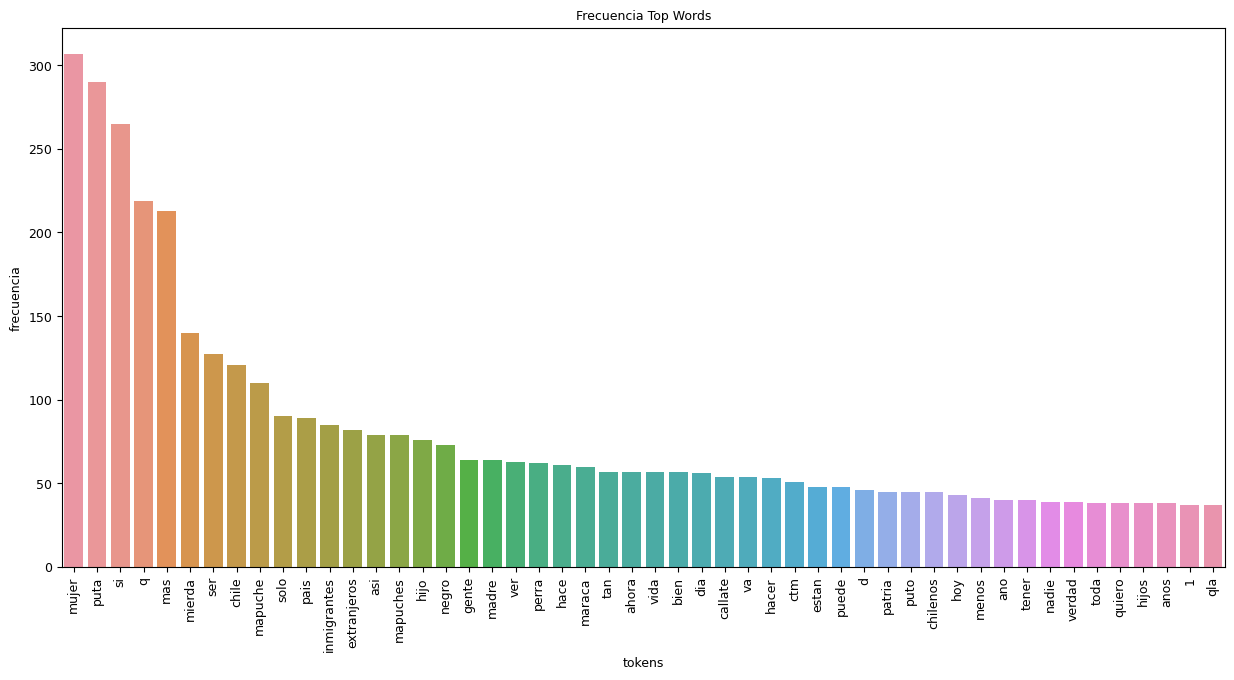

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

n_top_words = 50

tweets= [preprocess(tweet, cleaning=True, stopwords=True, stemming=False, lemmatizer=False, len_words=0).split() for tweet in train_data['text'].values]

top_words = Counter([item for sublist in [tweet for tweet in tweets] for item in sublist]).most_common(n_top_words)

fig, ax = plt.subplots(figsize=(15,7),nrows=1)
ax.set_title('Frecuencia Top Words',fontsize=9)
sns.barplot(x=[w[0] for w in top_words], y=[w[1] for w in top_words])
ax.set_xlabel("tokens",fontsize=9)
ax.set_ylabel("frecuencia",fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=9)
plt.xticks(rotation=90)
plt.show()

# Definición de modelo y datos a usar

In [32]:
CLEANING = True
STOPWORDS = True
STEMMING = False
LEMMATIZER = False
LEN_WORDS = 1

train_tweets = [preprocess(tweet, cleaning=CLEANING, stopwords=STOPWORDS, stemming=STEMMING, lemmatizer=LEMMATIZER, len_words=LEN_WORDS) for tweet in train_data['text'].values]
val_tweets = [preprocess(tweet) for tweet in val_data['text'].values]
y_train_categorias = train_data[classes].values
y_val_categorias = val_data[classes].values

print(y_train_categorias.shape)
print(y_val_categorias.shape)

(1917, 5)
(339, 5)


In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

n_max_words = 5000

Seq_tokenizer = Tokenizer(num_words=n_max_words)
Seq_tokenizer.fit_on_texts(train_tweets)

train_sequences = Seq_tokenizer.texts_to_sequences(train_tweets)
val_sequences = Seq_tokenizer.texts_to_sequences(val_tweets)

max_text_length = 50
train_sequences = pad_sequences(train_sequences, maxlen=max_text_length)
val_sequences = pad_sequences(val_sequences, maxlen=max_text_length)

In [34]:
import tensorflow_addons as tfa
METRICS = [
      tf.metrics.BinaryAccuracy(name='accuracy'),
      tfa.metrics.F1Score(name='F1',average='macro', num_classes=len(classes)),
      tf.metrics.Recall(name='recall')
]

In [35]:
wcounts = list(Seq_tokenizer.word_counts.items())
wcounts.sort(key=lambda x: x[1], reverse=True)
top_words = wcounts[:n_max_words]
top_words = [w[0] for w in top_words]
print(top_words)

['mujer', 'puta', 'si', 'mas', 'mierda', 'ser', 'chile', 'mapuche', 'solo', 'pais', 'inmigrantes', 'extranjeros', 'asi', 'mapuches', 'hijo', 'negro', 'gente', 'madre', 'ver', 'perra', 'hace', 'maraca', 'tan', 'ahora', 'vida', 'bien', 'dia', 'callate', 'va', 'hacer', 'ctm', 'estan', 'puede', 'patria', 'puto', 'chilenos', 'hoy', 'menos', 'ano', 'tener', 'nadie', 'verdad', 'toda', 'quiero', 'hijos', 'anos', 'qla', 'cara', 'gobierno', 'van', 'quieren', 'ahi', 'voy', 'mujeres', 'vez', 'venezolanos', 'gay', 'da', 'casa', 'mejor', 'mal', 'pueblo', 'siempre', 'dice', 'hija', 'personas', 'cada', 'tambien', 'decir', 'mundo', 'delincuentes', 'indigena', 'indio', 'gracias', 'peor', 'hombre', 'aqui', 'bueno', 'trabajo', 'creo', 'pasa', 'hecho', 'dios', 'ir', 'favor', 'persona', 'nunca', 'pa', 'cuenta', 'buena', 'parte', 'dar', 'vos', 'feminista', 'negra', 'loca', 'mismo', 'culia', 'asco', 'alguien', 'gran', 'poder', 'hacen', 'vieja', 'feliz', 'culiaos', 'vamos', 'usted', 'locas', 'falta', 'chileno'

In [36]:
# count the class distribution
class_counts = train_data[classes].sum(axis=0)
print(class_counts)

Odio                     840
Mujeres                  407
Comunidad LGBTQ+         127
Comunidades Migrantes    273
Pueblos Originarios      249
dtype: int64


## Embeddings pre-hechos

In [37]:
USE_PRETRAINED = False

if USE_PRETRAINED:
    emd_dim = 300

    emb_dict = {}

    glove_file = 'SBW-vectors-300-min5.txt'
    glove_dir = ''#path to the file

    glove = open(glove_dir+glove_file)
    for line in glove:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        emb_dict[word] = vector

    glove.close()

In [38]:
if USE_PRETRAINED:
  n_max_words_vis = 5000
  wcounts = list(Seq_tokenizer.word_counts.items())
  wcounts.sort(key=lambda x: x[1], reverse=True)
  top_words = wcounts[:n_max_words_vis]
  top_words = [w[0] for w in top_words]
  reverse_word_index = dict([(value, key) for (key, value) in Seq_tokenizer.word_index.items()])

  top_words[:10]

  word_index = Seq_tokenizer.word_index
  emb_matrix = np.zeros((n_max_words, emd_dim))

  not_found = 0
  for word in top_words[:-1]:
    vect = emb_dict.get(word)
    idx_word = word_index[word]
    if vect is not None:
      emb_matrix[idx_word] = vect
    else:
      emb_matrix[idx_word] = np.random.normal(0,0.1,emd_dim) # (La estrategia es asignar un vector aleatorio)
      not_found+=1

  print("Palabras del Diccionario no Encontradas en Glove ", not_found, " DE ", n_max_words)

# Entrenamiento

In [39]:
from tensorflow.keras import layers


class TransformerBlock(layers.Layer):
    num_heads=2
    ff_dim=64
    embed_dim = 200

    def __init__(self, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(self.ff_dim, activation="relu"), layers.Dense(self.embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim
        })
        return config
    
class TokenAndPositionEmbedding(layers.Layer):

    vocab_size = 5000
    maxlen = 50
    embed_dim = 200

    def __init__(self):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=self.vocab_size, output_dim=self.embed_dim)
        self.pos_emb = layers.Embedding(input_dim=self.maxlen, output_dim=self.embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'maxlen': self.maxlen,
            'vocab_size': self.vocab_size
        })
        return config


In [41]:
vocab_size = 5000
maxlen = 50
embed_dim = 200

def transformer_model():
  inputs = layers.Input(shape=(maxlen,))
  embedding_layer = TokenAndPositionEmbedding()
  x = embedding_layer(inputs)
  x = TransformerBlock()(x)
  x = TransformerBlock()(x)
  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dropout(0.4)(x)
  x = layers.Dense(400, activation="relu")(x)
  x = layers.Dropout(0.4)(x)
  outputs = layers.Dense(len(classes), activation="sigmoid")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

transformer_ = transformer_model()
transformer_.compile(optimizer="adam", loss="binary_crossentropy", metrics=METRICS)
transformer_.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50)]              0         
                                                                 
 token_and_position_embeddin  (None, 50, 200)          1010000   
 g_3 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_6 (Transf  (None, 50, 200)          348064    
 ormerBlock)                                                     
                                                                 
 transformer_block_7 (Transf  (None, 50, 200)          348064    
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_3   (None, 200)              0   

In [44]:
if len(classes) == 1:
    metrica_monitoreada = 'val_accuracy'
else:
    metrica_monitoreada = 'val_F1'

print("metrica monitoreada", metrica_monitoreada)

checkpoint_path = 'Transformer_checkpoints/Transformer.{epoch:02d}-{val_F1:.4f}.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,save_best_only=True,monitor=metrica_monitoreada,mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor=metrica_monitoreada, patience=5, restore_best_weights=True, mode='max')
history_transformer_model = transformer_.fit(train_sequences, y_train_categorias, epochs=40, batch_size=4, validation_data=(val_sequences, y_val_categorias), callbacks=[es])

metrica monitoreada val_F1
Epoch 1/40
480/480 [==============================] - 13s 27ms/step - loss: 0.2021 - accuracy: 0.9223 - F1: 0.3905 - recall: 0.8059 - val_loss: 0.3327 - val_accuracy: 0.8631 - val_F1: 0.4542 - val_recall: 0.7638
Epoch 2/40
480/480 [==============================] - 13s 27ms/step - loss: 0.1942 - accuracy: 0.9303 - F1: 0.4215 - recall: 0.8254 - val_loss: 0.3567 - val_accuracy: 0.8531 - val_F1: 0.3830 - val_recall: 0.7843
Epoch 3/40
480/480 [==============================] - 12s 25ms/step - loss: 0.1703 - accuracy: 0.9376 - F1: 0.4794 - recall: 0.8639 - val_loss: 0.4099 - val_accuracy: 0.8649 - val_F1: 0.3428 - val_recall: 0.7580
Epoch 4/40
480/480 [==============================] - 13s 27ms/step - loss: 0.1704 - accuracy: 0.9406 - F1: 0.4497 - recall: 0.8745 - val_loss: 0.4508 - val_accuracy: 0.8549 - val_F1: 0.3129 - val_recall: 0.7522
Epoch 5/40
480/480 [==============================] - 13s 28ms/step - loss: 0.1614 - accuracy: 0.9403 - F1: 0.4896 - recall: 

In [20]:
transformer_.save('Transformer_model/Transformer_'+str(len(classes))+'class_F1-{:.4f}.h5'.format((history_transformer_model.history['val_F1'][-1])))

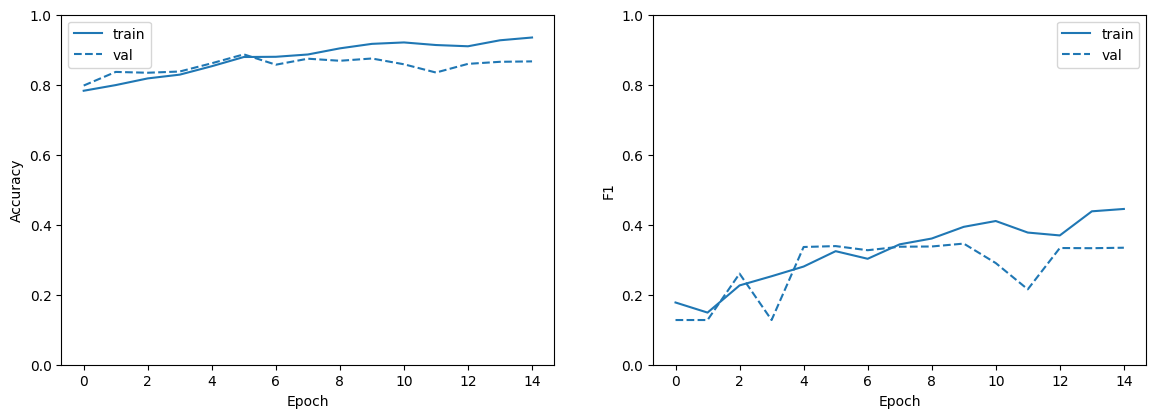

In [43]:
plot_metrics(history_transformer_model)

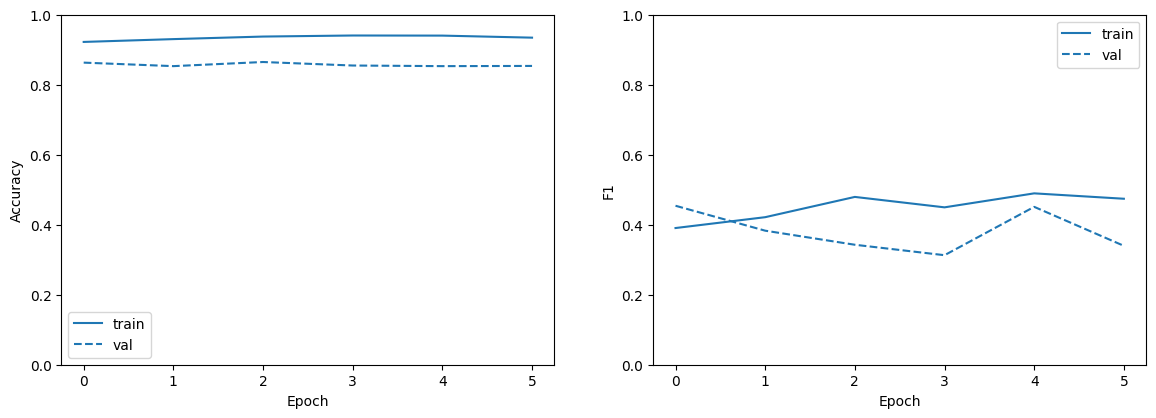

In [45]:
plot_metrics(history_transformer_model)

# Predicciones

In [22]:
#test_data = pd.read_csv('data/public_test.csv')
#test_tweets = [preprocess(tweet) for tweet in test_data['text'].values]
#
#y_pred_categorias = bert_model.predict(bert_input_test)
#for row in y_pred_categorias:
#    for i in range(len(classes)):
#        if row[i] > 0.5:
#            row[i] = 1
#        else:
#            row[i] = 0
#y_pred_categorias = pd.DataFrame(y_pred_categorias, columns=[classes])
#y_pred_categorias.to_csv('predicciones.csv', index=False)
#y_pred_categorias

In [78]:
#!shutdown -s -t 60